# Yoga image classificaton
Problem statement: The interest is to make the model that will identify the yoga asanas, there are 107 type of yoga asanas here in the data set. The data size is around 1 gb. The model is built using functional api and transfer learning of mobile net

#### Importing libraries

In [2]:
!pip install opencv-python-headless


  Obtaining dependency information for opencv-python-headless from https://files.pythonhosted.org/packages/20/44/458a0a135866f5e08266566b32ad9a182a7a059a894effe6c41a9c841ff1/opencv_python_headless-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
   ---------------------------------------- 0.0/38.5 MB ? eta -:--:--
   ---------------------------------------- 0.1/38.5 MB 1.3 MB/s eta 0:00:31
   ---------------------------------------- 0.4/38.5 MB 5.1 MB/s eta 0:00:08
    --------------------------------------- 0.8/38.5 MB 6.4 MB/s eta 0:00:06
   - -------------------------------------- 1.0/38.5 MB 5.7 MB/s eta 0:00:07
   - -------------------------------------- 1.2/38.5 MB 5.4 MB/s eta 0:00:07
   - -------------------------------------- 1.4/38.5 MB 5.1 MB/s eta 0:00:08
   - -------------------------------------- 1.5/38.5 MB 4.9 MB/s eta 0:00:08
   - -------------------------------------- 1.7/38.5 MB 4.8 MB/s eta 0:00:08
   - -------------------------------------- 1.9/38.5 MB 4.7 MB/s eta 0:00:0

In [4]:
!pip install shap


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/39/6c/4ab39615fc3ffe40faaa62fc2feb43868b8ce946c671e84bf476c1e06116/shap-0.45.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.7 from https://files.pythonhosted.org/packages/78/c2/b3f55dfdb8af9812fdb9baf70cacf3b9e82e505b2bd4324d588888b81202/slicer-0.0.7-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/453.1 kB ? eta -:--:--
   ------------------ --------------------- 204.8/453.1 kB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 453.1/453.1 kB 7.1 MB/s eta 0:00:00


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [8]:
!pip install --upgrade tensorflow


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import shap
import seaborn as sns
from sklearn import preprocessing
import tensorflow.keras.layers as tfl
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from os import walk
for (dirpath, dirnames, filenames) in walk("../input/yoga-poses-dataset/DATASET"):
    print("Directory path: ", dirpath)


In [16]:
import os

def print_directory_tree(directory, indent=''):
    print(indent + '|--', os.path.basename(directory))
    indent += '   '
    for item in os.listdir(directory):
        path = os.path.join(directory, item)
        if os.path.isdir(path):
            print_directory_tree(path, indent)
        else:
            print(indent + '|--', item)

# Replace 'C:\\Users\\divya\\Downloads\\archive\\DATASET' with your directory path
directory_path = 'C:\\Users\\divya\\Downloads\\archive\\DATASET'
print_directory_tree(directory_path)


|-- DATASET
   |-- TEST
      |-- downdog
         |-- 00000000.jpg
         |-- 00000001.JPG
         |-- 00000002.jpg
         |-- 00000003.jpg
         |-- 00000004.jpg
         |-- 00000005.jpg
         |-- 00000006.jpg
         |-- 00000007.jpg
         |-- 00000008.jpg
         |-- 00000009.jpg
         |-- 00000010.png
         |-- 00000011.jpg
         |-- 00000012.jpg
         |-- 00000013.jpg
         |-- 00000014.jpg
         |-- 00000016.jpg
         |-- 00000017.png
         |-- 00000018.jpg
         |-- 00000019.jpg
         |-- 00000020.jpg
         |-- 00000021.jpg
         |-- 00000022.jpg
         |-- 00000023.jpg
         |-- 00000024.jpg
         |-- 00000025.jpg
         |-- 00000026.jpg
         |-- 00000027.jpg
         |-- 00000029.jpg
         |-- 00000030.jpg
         |-- 00000031.jpg
         |-- 00000032.jpg
         |-- 00000033.jpg
         |-- 00000035.jpg
         |-- 00000037.jpg
         |-- 00000038.jpg
         |-- 00000039.jpg
         |-- 00000040.

In [17]:
train_path = r"C:\Users\divya\Downloads\archive\DATASET\TRAIN"
test_path = r"C:\Users\divya\Downloads\archive\DATASET\TEST"

Data Preprocessing¶
Histogram Equalization
Histogram Equalization is used for improving the contrast of any image, that is- to make the dark portion darker and the bright portion brighter. For a grey-scale image, each pixel is represented by the intensity value (brightness); that is why we can feed the pixel values directly to the HE function. However, that is not how it works for an RGB-formatted color image. Each channel of the R, G, and B represents the intensity of the related color, not the intensity/brightness of the image as a whole. And so, running HE on these color channels is NOT the proper way. We should first separate the brightness of the image from the color and then run HE on the brightness. Now, there are already standardized colorspaces that encode brightness and color separately, like- YCbCr, HSV, etc.; so, we can use them here for separating and then re-merging the brightness

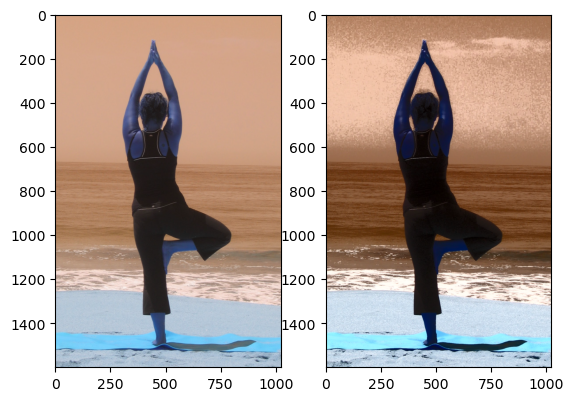

In [18]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')

# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2YCrCb)
 # equalize the histogram of the Y channel
ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

plt.subplot(121),plt.imshow(bgr_img)

plt.subplot(122),plt.imshow(equalized_img)
plt.show()

CLAHE (Contrast Limited Adaptive Histogram Equalization)
Now the input image’s contrast has improved significantly but at the expense of also boosting the contrast of the noise in the input image. We can solve this problem by using adaptive histogram equalization

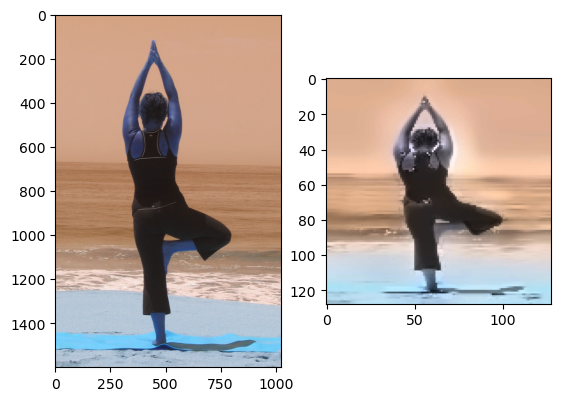

In [19]:
bgr_img = cv2.imread(train_path+'/tree/00000070.jpg')
# dsize
dsize = (128,128)
resized_image = cv2.resize(bgr_img,dsize)
# convert from BGR color-space to YCrCb
ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
# create a CLAHE object 
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Now apply on the YCrCb image 
ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
# convert back to BGR color-space from YCrCb
equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

# Denoise is done to remove unwanted noise to better perform
equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)

plt.subplot(121),plt.imshow(bgr_img)
plt.subplot(122),plt.imshow(equalized_denoised_image)
plt.show()

In [20]:
def preprocess_images(dataset_path):
    images_data = []
    images_label = []
    class_names = os.listdir(dataset_path)
    for class_name in class_names:
        images_path = dataset_path + '/' + class_name
        images = os.listdir(images_path)
        for image in images:
            bgr_img = cv2.imread(images_path + '/' + image)
            # dsize
            dsize = (64,64)
            #resize image
            resized_image = cv2.resize(bgr_img,dsize)
            # convert from BGR color-space to YCrCb
            ycrcb_img = cv2.cvtColor(resized_image, cv2.COLOR_BGR2YCrCb)
            # create a CLAHE object 
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            # Now apply CLAHE object on the YCrCb image
            ycrcb_img[:, :, 0] = clahe.apply(ycrcb_img[:, :, 0])
            # convert back to BGR color-space from YCrCb
            equalized_img = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)
            # Denoise is done to remove unwanted noise to better perform
            equalized_denoised_image = cv2.fastNlMeansDenoisingColored(equalized_img, None, 10, 10, 7, 21)
            
            images_data.append(equalized_denoised_image/255)
            images_label.append(class_name)
    images_data = np.array(images_data)
    images_label = np.array(images_label)
    return images_data, images_label

In [21]:
train_images_data, train_images_label = preprocess_images(train_path)

In [22]:
def encoding_targets(labels):
    le = preprocessing.LabelEncoder()
    images_label = le.fit_transform(labels)
    return images_label

In [23]:
class_names = os.listdir(train_path)
class_num = len(class_names)
train_images_label = encoding_targets(train_images_label)

In [25]:
from tensorflow.keras.layers import Input

model = tf.keras.Sequential([
        Input(shape=(64, 64, 3)),
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),    
        tfl.Flatten(),
        tfl.Dense(512, activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
        tfl.Dense(class_num, activation='softmax')
])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 29, 29, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 29, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 27, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     5,538,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,566,885 (21.24 MB)

 Trainable params: 5,565,669 (21.23 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [27]:
epochs = 20
learning_rate = 0.001
opt = Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [28]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True,random_state=2)

In [29]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(train_images_data[train], train_images_label[train], batch_size=16, 
                        epochs=epochs, validation_data=(train_images_data[valid], train_images_label[valid]))
    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.3711 - loss: 2.4731 - val_accuracy: 0.1567 - val_loss: 1.6542
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5790 - loss: 1.2845 - val_accuracy: 0.4055 - val_loss: 1.4724
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.7056 - loss: 0.8474 - val_accuracy: 0.2581 - val_loss: 1.7193
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.7585 - loss: 0.6771 - val_accuracy: 0.4147 - val_loss: 1.9739
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.8220 - loss: 0.5180 - val_accuracy: 0.4700 - val_loss: 1.7155
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8804 - loss: 0.3488 - val_accuracy: 0.4055 - val_loss: 1.9411
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.9049 - loss: 0.2812 - val_accuracy: 0.4977 - val_loss: 1.4136
Epoch 8/20
54/

In [30]:
print(f'> Mean_Training_Accuracy: {np.mean(acc_per_fold)*100} (+- {np.std(acc_per_fold)})')
print(f'> Mean_Validation_Accuracy: {np.mean(val_acc_per_fold)*100} (+- {np.std(val_acc_per_fold)})')

> Mean_Training_Accuracy: 96.01912051439285 (+- 0.08084133126683704)
> Mean_Validation_Accuracy: 89.33177624642849 (+- 0.18258042164042815)


Evaluation and Optimization
Overfitting Issue
> Training_Accuracy: 94.34937888383865 (+- 0.10064080565561062)
> Validation_Accuracy: 86.20323440432549 (+- 0.23861513322009303)
Data Augmentation
So far we are working human postures and the flip of postures can change the definition of yoga poses. As a result model emits poor result when flip(horizontal_flip, vertical_flip) parameters are passed True

In [31]:
dataAugmentaion = ImageDataGenerator(rotation_range = 10, zoom_range = 0.30, 
                                        fill_mode = "nearest", shear_range = 0.30)

In [33]:
# Define per-fold score containers
val_acc_per_fold = []
val_loss_per_fold = []
loss_per_fold = []
acc_per_fold = []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, valid in kfold.split(train_images_data, train_images_label):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    history = model.fit(dataAugmentaion.flow(train_images_data[train], train_images_label[train], batch_size=16),
                    epochs=epochs,
                    validation_data=(train_images_data[valid], train_images_label[valid]))

    val_acc_per_fold.append(history.history['val_accuracy'])
    acc_per_fold.append(history.history['accuracy'])
    val_loss_per_fold.append(history.history['val_loss'])
    loss_per_fold.append(history.history['loss'])
    # Increase fold number
    fold_no += 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.6562 - loss: 1.5536  

D:\ana\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6873 - loss: 1.5537 - val_accuracy: 0.3779 - val_loss: 7.1939
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6366 - loss: 1.4503 - val_accuracy: 0.7742 - val_loss: 0.7844
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6593 - loss: 1.2017 - val_accuracy: 0.8157 - val_loss: 0.7750
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.6774 - loss: 1.0240 - val_accuracy: 0.8802 - val_loss: 0.3052
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7186 - loss: 0.7987 - val_accuracy: 0.9078 - val_loss: 0.3187
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.7753 - loss: 0.6158 - val_accuracy: 0.8571 - val_loss: 0.3901
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.7624 - loss: 0.6900 - val_accuracy: 0.8479 - val_loss: 0.5124
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7931 - loss: 0.6425 - val_accuracy: 0.8894 - val_loss: 0.

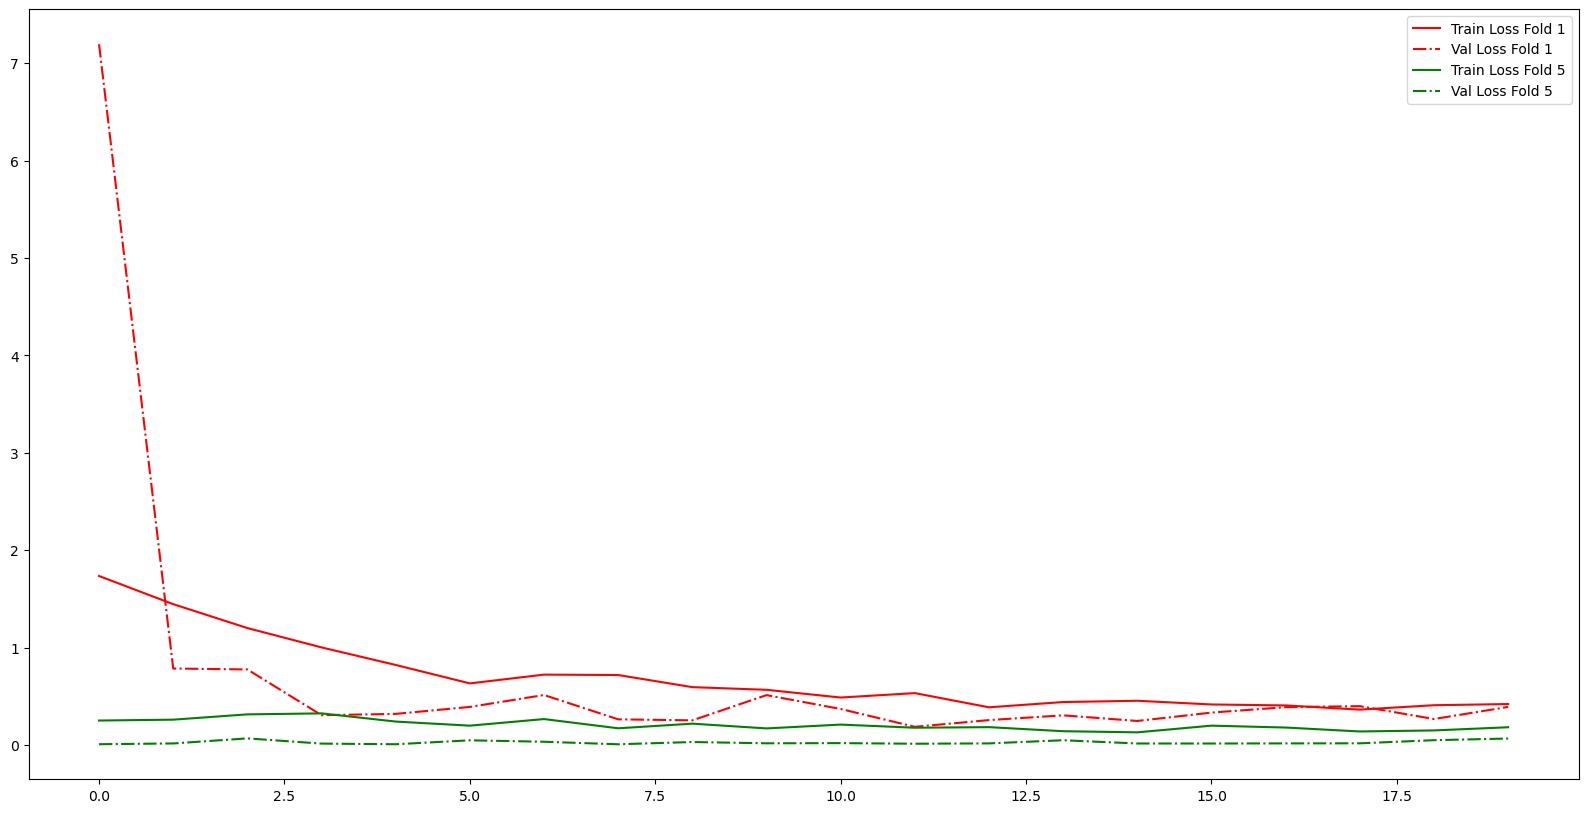

In [34]:
plt.figure(figsize=(20, 10))
plt.plot(loss_per_fold[0], label='Train Loss Fold 1', color='red')
plt.plot(val_loss_per_fold[0], label='Val Loss Fold 1', color='red', linestyle = "dashdot")
plt.plot(loss_per_fold[4], label='Train Loss Fold 5', color='green')
plt.plot(val_loss_per_fold[4], label='Val Loss Fold 5', color='green', linestyle = "dashdot")
plt.legend()
plt.show()

In [35]:
test_images_data, test_images_label = preprocess_images(test_path)
test_images_label = encoding_targets(test_images_label)
predict = np.argmax(model.predict(np.array(test_images_data)),axis=1)
print('Test Data accuracy: ',accuracy_score(test_images_label, predict)*100)
print("\nConfusion Matrix : ")
cnf_matrix = confusion_matrix(test_images_label, predict)
print(cnf_matrix)
print("\nClassification Report :")
print(classification_report(test_images_label, predict, target_names=class_names))

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Test Data accuracy:  90.0

Confusion Matrix : 
[[ 91   0   3   1   2]
 [  0  58   9   7   6]
 [  0   1 110   2   2]
 [  0   1   0  68   0]
 [  1  10   0   2  96]]

Classification Report :
              precision    recall  f1-score   support

     downdog       0.99      0.94      0.96        97
     goddess       0.83      0.72      0.77        80
       plank       0.90      0.96      0.93       115
        tree       0.85      0.99      0.91        69
    warrior2       0.91      0.88      0.89       109

    accuracy                           0.90       470
   macro avg       0.90      0.90      0.89       470
weighted avg       0.90      0.90      0.90       470



From heatmap visualization we can see a lot of goddess images were predicted as warrior2

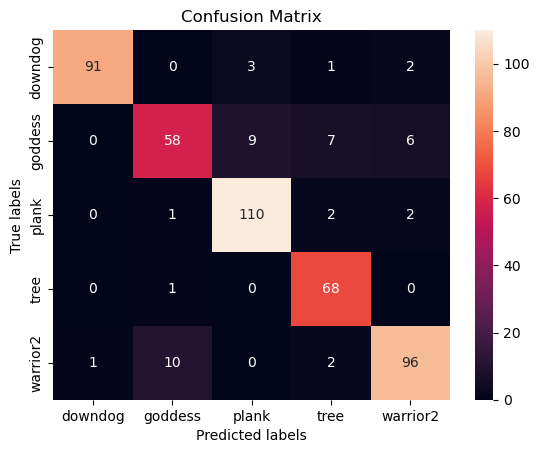

In [36]:
ax= plt.subplot()
sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']); ax.yaxis.set_ticklabels(['downdog', 'goddess','plank','tree','warrior2']);

Visualize Model
The chart shows the actual image and parts of it highlighted in shades of red and blue colors. The shades of red color show parts that contributed positively and shades of blue color show parts that contributed negatively to the prediction of that category

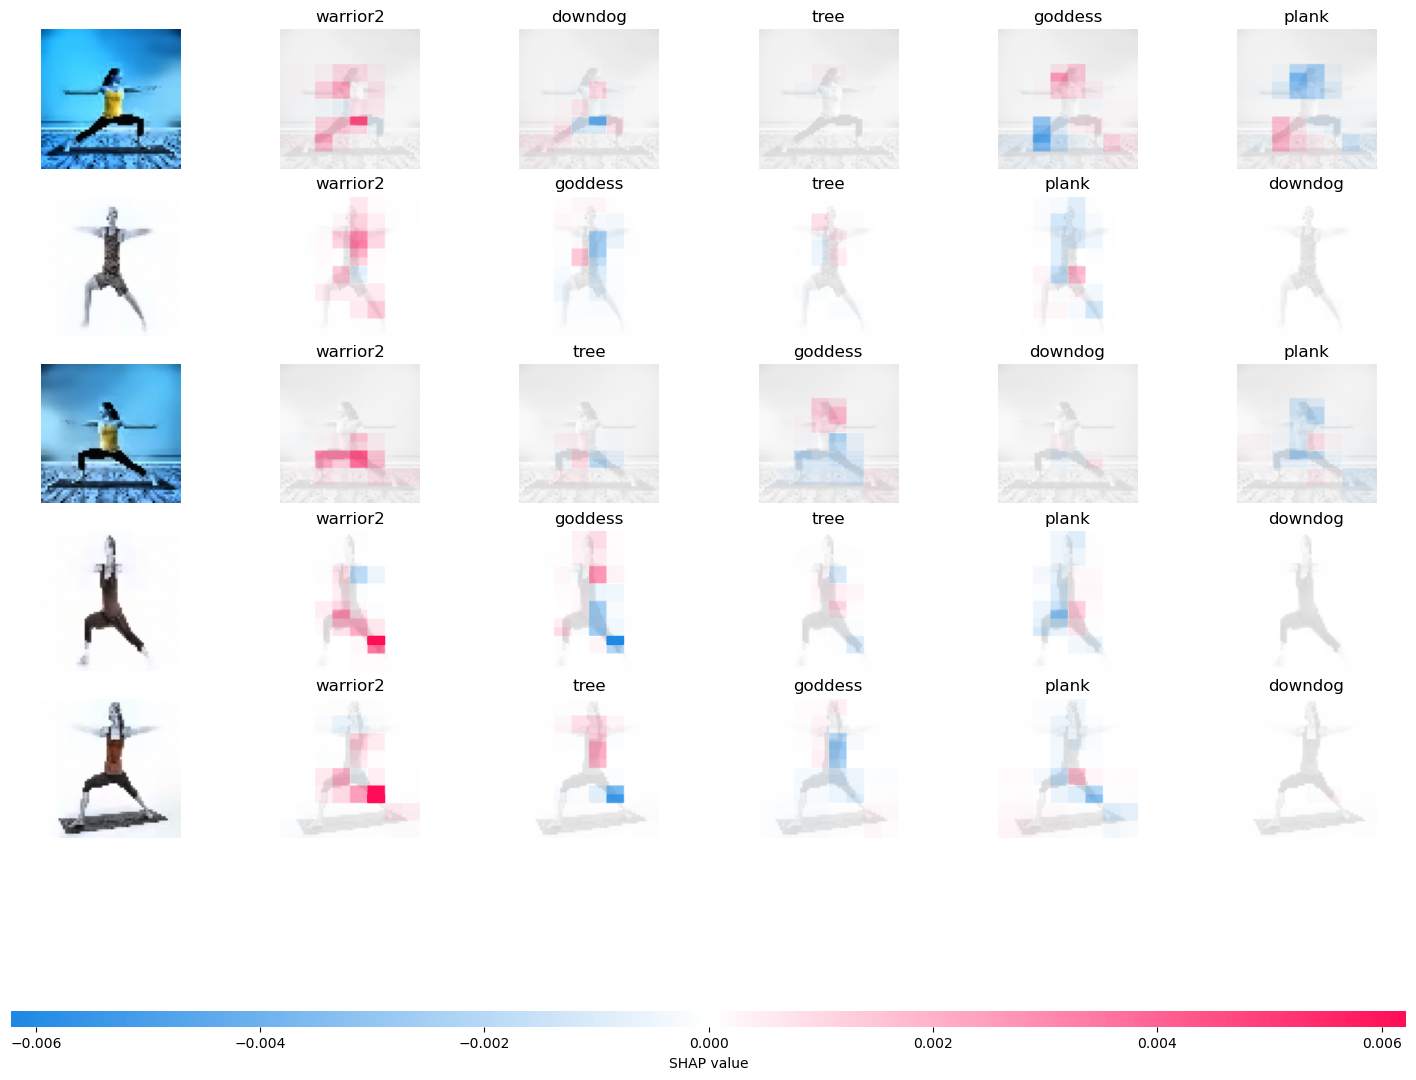

In [37]:
shap.initjs()
#Masker to mask parts of an image using blurring
masker = shap.maskers.Image("blur(64,64)", train_images_data[0].shape)
#Explainer() constructor by default creates an instance of Partition explainer
explainer = shap.Explainer(model, masker, output_names=class_names)
#generate shap values for images using the explainer object
shap_values = explainer(test_images_data[361:366], outputs=shap.Explanation.argsort.flip[:5])
shap.image_plot(shap_values)